## Importazione librerie

In [55]:
import pandas as pd
import numpy as np
from datetime import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Add, Activation, Dense, Lambda, concatenate, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import GlorotUniform
import scipy.stats

## Caricamento del dataset originale
Il dataset originale è composto da 4 colonne:   
- user_id: identificatore dell'utente
- date: giorno in cui è stato raccolto il dato aggregato
- data_type: intero che identifica la tipologia di dato raccolto
- data_value: valore associato al dato raccolto

I diversi valori della variabile data_type si riferiscono a dati aggregati raccolti giornalmente dal dispositivo di ogni singolo utente e identificano le tipologie di dato in base al seguente schema:
- 1: numero totale di passi effettuati
- 2: peso (kg)
- 3: BMI (kg/m^2)
- 4: pressione sanguigna sistolica (mmHg)
- 5: velocità dell'onda sfigmica arteriosa (PWV), (m/s)
- 6: PWV healthiness (1: bassa, 2: sano, 3: troppo alta)
- 7: frequenza cardiaca media (bpm)
- 8: frequenza cardiaca minima (bpm)
- 9: frequenza cardiaca massima (bpm)
- 10: durata del sonno (ore)
- 11: orario in cui l'utente si è messo a letto
- 12: orario in cui l'utente si è alzato dal letto
- 13: numero di volte in cui l'utente si è svegliato durante il sonno
- 14: durata del tempo in cui l'utente si è svegliato durante il sonno (ore)
- 15: tempo impiegato dall'utente per addormentarsi (ore)
- 16: tempo impiegato dall'utente per alzarsi dal letto (ore)
- 17: durata di sonno leggero (ore)
- 18: durata di sonno REM (ore)
- 19: durata di sonno profondo (ore)
- 20: tipo di attività
- 21: durata dell'attività (secondi)
- 22: calorie consumate durante l'attività
- 23: frequenza cardiaca media durante l'attività (bpm)
- 24: frequenza cardiaca minima durante l'attività (bpm)
- 25: frequenza cardiaca massima durante l'attività (bpm)
- 26: velocità dell'andatura dei passi (passi al minuto)
- 27: velocità dell'andatura a distanza (km all'ora)

In [3]:
raw_dataset = pd.read_csv('./data.csv', usecols=['user_id', 'date', 'data_type', 'data_value'])

raw_dataset.head()

,user_id,date,data_type,data_value
0,2bc16eda651db5936cd31e735c815296fc1579d9,2016-04-01,1,10131.39
1,2bc16eda651db5936cd31e735c815296fc1579d9,2016-04-01,2,86.80
2,2bc16eda651db5936cd31e735c815296fc1579d9,2016-04-01,3,28.96
3,2bc16eda651db5936cd31e735c815296fc1579d9,2016-04-01,7,117.62
4,2bc16eda651db5936cd31e735c815296fc1579d9,2016-04-01,8,117.86


## Creazione del dataset personalizzato
L'obiettivo del progetto è quello di valutare se è possibile stimare, attraverso strumenti di deep learning, la qualità del sonno di un utente a partire dalle informazioni sulla durata del sonno e sull'andamento dei passi. Per raggiungere tale scopo è necessario costruire un nuovo dataset personalizzato contenente i soli dati utili per questa analisi, in particolare i dati riguardanti il sonno e l'andatura dei passi degli utenti.

In [4]:
feature_types = [10, 11, 12, 14, 15, 18, 19, 26]
feature_names = ["sleepduration", "bedin", "bedout", "awakeduration", "timetosleep", "remduration", "deepduration", "stepsgaitspeed"]

dataset_array = []

for i in range(len(feature_types)):
    dataset_feature = raw_dataset[raw_dataset['data_type'] == feature_types[i]].copy(deep=True)
    dataset_feature.drop(raw_dataset.columns[[2]], axis=1, inplace=True)
    dataset_feature.columns = ["user_id", "date", feature_names[i]]
    dataset_array.append(dataset_feature)

dataset = dataset_array[0]
for i in range(1, len(dataset_array)):
    dataset = dataset.merge(dataset_array[i], on=["user_id", "date"], how="outer")

# rimozione delle righe del dataset che non contengono i valori più importanti per lo studio
dataset = dataset.dropna(subset=['sleepduration', 'stepsgaitspeed'])

dataset.set_index(['user_id','date'], inplace=True)

# salvataggio del dataset in un file locale
dataset.to_csv('dataset.csv')
dataset.head()

sleepduration  bedin  \
user_id                                  date                               
1003e58667235e01b49008155604980b3900b00e 2016-08-01          11.31  22.11   
                                         2016-08-10           9.15  22.34   
                                         2016-08-15           7.87  23.93   
                                         2016-09-05           8.34  22.70   
                                         2016-09-06           8.08  23.55   

                                                     bedout  awakeduration  \
user_id                                  date                                
1003e58667235e01b49008155604980b3900b00e 2016-08-01    9.86           0.53   
                                         2016-08-10    7.66           0.28   
                                         2016-08-15    7.95           0.27   
                                         2016-09-05    7.16           0.28   
                                         2016-09-06    7.72           0.20   

                                                     timetosleep  remduration  \
user_id                                  date                                   
1003e58667235e01b49008155604980b3900b00e 2016-08-01         0.15          NaN   
                                         2016-08-10         0.02          NaN   
                                         2016-08-15         0.02          NaN   
                                         2016-09-05         0.10          NaN   
                                         2016-09-06         0.00          NaN   

                                                     deepduration  \
user_id                                  date                       
1003e58667235e01b49008155604980b3900b00e 2016-08-01          3.99   
                                         2016-08-10          3.58   
                                         2016-08-15          3.19   
                                         2016-09-05          3.11   
                                         2016-09-06          3.60   

                                                     stepsgaitspeed  
user_id                                  date                        
1003e58667235e01b49008155604980b3900b00e 2016-08-01          108.81  
                                         2016-08-10          105.02  
                                         2016-08-15           88.27  
                                         2016-09-05           84.91  
                                         2016-09-06           88.60

## Analisi del dataset personalizzato


In [5]:
dataset = pd.read_csv('./dataset.csv')

Per estrarre delle sequenze di giorni significative, è necessario trovare nei dati delle sequenze di giorni che non abbiano troppi dati mancanti. Nello studio sono state selezionate delle sequenze di giorni di lunghezza 15 in cui ogni giorno è seguito al più da un singolo giorno mancante.

In [6]:
# metodo che trasforma una data in un intero (la data zero è allineata a quella del dataset e corrisponde al giorno 2016-04-01)
def date_to_int(date):
    d1 = datetime.strptime('2016-04-01', "%Y-%m-%d")
    d2 = datetime.strptime(date, "%Y-%m-%d")
    return (d2 - d1).days

In [7]:
# trasformazione delle date in interi per semplificare il confronto
dataset['date'] = dataset['date'].apply(date_to_int)
dataset.set_index(['user_id','date'], inplace=True)
dataset.head()

sleepduration  bedin  bedout  \
user_id                                  date                                 
1003e58667235e01b49008155604980b3900b00e 122           11.31  22.11    9.86   
                                         131            9.15  22.34    7.66   
                                         136            7.87  23.93    7.95   
                                         157            8.34  22.70    7.16   
                                         158            8.08  23.55    7.72   

                                               awakeduration  timetosleep  \
user_id                                  date                               
1003e58667235e01b49008155604980b3900b00e 122            0.53         0.15   
                                         131            0.28         0.02   
                                         136            0.27         0.02   
                                         157            0.28         0.10   
                                         158            0.20         0.00   

                                               remduration  deepduration  \
user_id                                  date                              
1003e58667235e01b49008155604980b3900b00e 122           NaN          3.99   
                                         131           NaN          3.58   
                                         136           NaN          3.19   
                                         157           NaN          3.11   
                                         158           NaN          3.60   

                                               stepsgaitspeed  
user_id                                  date                  
1003e58667235e01b49008155604980b3900b00e 122           108.81  
                                         131           105.02  
                                         136            88.27  
                                         157            84.91  
                                         158            88.60

In [8]:
target_sequence_len = 15
last_user = None
last_date = None
current_sequence = []
sequences = []
count = 1

# estrazione di sequenze di lunghezza target_sequence_len che soddisfano i criteri stabiliti (ogni giorno è seguito al più da un singolo giorno mancante)
for index, row in dataset.iterrows():
    user, date = index
    if last_user != None:
        if user == last_user:
            if date == last_date + 1 or date == last_date + 2:
                current_sequence.append((index, row))
                if len(current_sequence) == target_sequence_len:
                    sequences.append(current_sequence[::])
                    current_sequence.pop(0)
            else:
                current_sequence = []
        else:
            current_sequence = []
    else:
        current_sequence.append((index, row))
    last_user = user
    last_date = date

print(f'trovate {len(sequences)} sequenze di lunghezza {target_sequence_len}')

trovate 273472 sequenze di lunghezza 15


In [9]:
# visualizzazione dei giorni considerati per alcune sequenze
for sequence in sequences[20:30]:
    test_sequence = []
    for index, row in sequence:
        test_sequence.append(index[1])
    print(test_sequence)

[344, 345, 346, 348, 349, 351, 352, 353, 354, 355, 357, 358, 359, 360, 361]
[345, 346, 348, 349, 351, 352, 353, 354, 355, 357, 358, 359, 360, 361, 362]
[346, 348, 349, 351, 352, 353, 354, 355, 357, 358, 359, 360, 361, 362, 364]
[172, 173, 174, 175, 176, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188]
[173, 174, 175, 176, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189]
[174, 175, 176, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 191]
[175, 176, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 191, 192]
[176, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193]
[178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194]
[179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195]


Per poter estrarre dalle sequenze di giorni delle caratteristiche rilevanti, è necessario addestrare un modello sull'analisi delle sequenze. Il modello scelto in questo progetto per estrarre caratteristiche dalle sequenze di dati si basa sull'architettura WaveNet. Tale architettura, è stata addestrata sul task di forecasting, cioè, data una sequenza di 14 giorni contenente i valori di una variabile nei diversi giorni come input, il modello ha il compito di prevedere il valore di tale variabile al giorno 15.
Ai scopi del progetto sono dunque necessarie due WaveNet distinte, una addestrata sul task di previsione della durata del sonno e l'altra sul task di previsione dell'andatura dei passi. È quindi necessario creare i dati di addestramento per tali modelli.

Per poter addestrare il modello finale nella stima della qualità del sonno è necessario calcolare i valori reali di qualità del sonno a partire dai dati sul sonno presenti nel dataset. La qualità del sonno viene quindi calcolata attraverso una versione rivisitata del Pittsburgh Sleep Quality Index (PSQI) in modo da poter includere nel calcolo dell'indice anche i dati riguardanti la durata del sonno profondo e la durata del sonno REM.

In [10]:
def get_sleep_quality(timetosleep, sleepduration, bedin, bedout, awakeduration, remduration, deepduration):
    sleep_quality = 0

    if not pd.isna(timetosleep):
        if timetosleep > 0.25 and timetosleep <= 0.5:
            sleep_quality += 1
        elif timetosleep > 0.5 and timetosleep <= 1:
            sleep_quality += 2
        elif timetosleep > 1:
            sleep_quality += 3

    if not sleepduration:
        return 14
    
    if sleepduration > 6 and sleepduration <= 7:
        sleep_quality += 1
    elif sleepduration > 5 and sleepduration <= 6:
        sleep_quality += 2
    elif sleepduration <= 5:
        sleep_quality += 3

    if not pd.isna(bedin) and not pd.isna(bedout):
        timeinbed = bedout + 24 - bedin
        sleep_efficiency = sleepduration / timeinbed

        if sleep_efficiency > 0.75 and sleep_efficiency <= 0.85:
            sleep_quality += 1
        elif sleep_efficiency > 0.65 and sleep_efficiency <= 0.75:
            sleep_quality += 2
        elif sleep_efficiency <= 0.65:
            sleep_quality += 3

    if not pd.isna(awakeduration):
        if awakeduration > 1/3 and awakeduration <= 0.5:
            sleep_quality += 1
        elif awakeduration > 0.5 and awakeduration <= 2/3:
            sleep_quality += 2
        elif awakeduration > 2/3:
            sleep_quality += 3

    if not pd.isna(deepduration):
        percentage_deep = deepduration / sleepduration

        if percentage_deep <= 0.1:
            sleep_quality += 1

    if not pd.isna(remduration):
        percentage_rem = remduration / sleepduration

        if percentage_rem < 0.2 or percentage_rem > 0.25:
            sleep_quality += 1
    
    return sleep_quality

In [11]:
sleep_duration_sequences = []
sleep_quality_sequences = []
steps_gait_speed_sequences = []

for sequence in sequences:
    sleep_duration_sequence = []
    sleep_quality_sequence = []
    steps_gait_speed_sequence = []
    for index, row in sequence:
        sleep_duration_sequence.append(row['sleepduration'])

        sleep_quality = get_sleep_quality(row['timetosleep'], row['sleepduration'], row['bedin'], row['bedout'], row['awakeduration'], row['remduration'], row['deepduration'])
        sleep_quality_sequence.append(sleep_quality)

        steps_gait_speed_sequence.append(row['stepsgaitspeed'])
    
    sleep_duration_sequences.append(sleep_duration_sequence)
    sleep_quality_sequences.append(sleep_quality_sequence)
    steps_gait_speed_sequences.append(steps_gait_speed_sequence)

In [12]:
# creazione degli insiemi utili all'addestramento (sleep duration)
sleep_duration_x = []
sleep_duration_y = []

for sleep_duration_sequence in sleep_duration_sequences:
    sleep_duration_x.append(sleep_duration_sequence[:target_sequence_len - 1])
    sleep_duration_y.append(sleep_duration_sequence[target_sequence_len - 1])

In [13]:
# creazione degli insiemi utili all'addestramento (steps gait speed)
steps_gait_x = []
steps_gait_y = []

for steps_gait_speed_sequence in steps_gait_speed_sequences:
    steps_gait_x.append(steps_gait_speed_sequence[:target_sequence_len - 1])
    steps_gait_y.append(steps_gait_speed_sequence[target_sequence_len - 1])

## Definizione e addestramento delle reti WaveNet

In [14]:
train_set_len = (len(sleep_duration_x) * 80) // 100

sleep_duration_train_x = sleep_duration_x[:train_set_len]
sleep_duration_train_y = sleep_duration_y[:train_set_len]

sleep_duration_train_x = np.array(sleep_duration_train_x)
sleep_duration_train_y = np.array(sleep_duration_train_y)

# definizione dei parametri del modello
num_filters = 32
filter_size = 2
dilation_rates = [1, 2, 4, 8]

# Definizione WaveNet
input_sleep_duration = Input(shape=(target_sequence_len - 1, 1))

# Strato di convoluzione iniziale
conv_out = Conv1D(filters=num_filters, kernel_size=filter_size, padding='causal', dilation_rate=1)(input_sleep_duration)

# Strati convoluzionali dilatati
for dilation_rate in dilation_rates:
    conv = Conv1D(filters=num_filters, kernel_size=filter_size, padding='causal', dilation_rate=dilation_rate)(conv_out)
    conv = Activation('relu')(conv)
    conv_out = Add()([conv_out, conv])

# Strato di output finale
last_conv_layer_sleep_duration = Conv1D(filters=1, kernel_size=1, activation='linear')(conv_out)
outputs = Lambda(lambda x: x[:, -1, :])(last_conv_layer_sleep_duration)

# Costruzione del modello
model_sleep_duration = Model(inputs=input_sleep_duration, outputs=outputs)

# Compilazione del modello
model_sleep_duration.compile(optimizer=Adam(), loss='mse')

# Reshape dei dati per il modello
x = sleep_duration_train_x[..., np.newaxis]

# Addestramento del modello
history_sleep_duration = model_sleep_duration.fit(x, sleep_duration_train_y, epochs=10, batch_size=1024, validation_split=0.2)


Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 9.7403 - val_loss: 1.9080
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.9162 - val_loss: 1.8938
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.9154 - val_loss: 1.8856
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.8963 - val_loss: 1.8809
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.8771 - val_loss: 1.8767
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.9007 - val_loss: 1.8752
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.8994 - val_loss: 1.8728
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.8929 - val_loss: 1.8842
Epoch 9/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.8794 - val_loss: 1.8746
Epoch 10/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.8904 - val_loss: 1.8736


In [15]:
steps_gait_train_x = steps_gait_x[:train_set_len]
steps_gait_train_y = steps_gait_y[:train_set_len]

steps_gait_train_x = np.array(steps_gait_train_x)
steps_gait_train_y = np.array(steps_gait_train_y)

# definizione dei parametri del modello
num_filters = 32
filter_size = 2
dilation_rates = [1, 2, 4, 8]

# Definizione WaveNet
input_steps_gait = Input(shape=(target_sequence_len - 1, 1))

# Strato di convoluzione iniziale
conv_out = Conv1D(filters=num_filters, kernel_size=filter_size, padding='causal', dilation_rate=1)(input_steps_gait)

# Strati convoluzionali dilatati
for dilation_rate in dilation_rates:
    conv = Conv1D(filters=num_filters, kernel_size=filter_size, padding='causal', dilation_rate=dilation_rate)(conv_out)
    conv = Activation('relu')(conv)
    conv_out = Add()([conv_out, conv])

# Strato di output finale
last_conv_layer_steps_gait = Conv1D(filters=1, kernel_size=1, activation='linear')(conv_out)
outputs = Lambda(lambda x: x[:, -1, :])(last_conv_layer_steps_gait)

# Costruzione del modello
model_steps_gait = Model(inputs=input_steps_gait, outputs=outputs)

# Compilazione del modello
model_steps_gait.compile(optimizer=Adam(), loss='mse')

# Reshape dei dati per il modello
x = steps_gait_train_x[..., np.newaxis]

# Addestramento del modello
history_steps_gait = model_steps_gait.fit(x, steps_gait_train_y, epochs=10, batch_size=1024, validation_split=0.2)

Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 152.3053 - val_loss: 103.1588
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 102.9666 - val_loss: 102.6915
Epoch 3/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 102.2917 - val_loss: 101.8089
Epoch 4/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 100.7990 - val_loss: 102.6149
Epoch 5/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 101.0612 - val_loss: 101.6665
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 101.7520 - val_loss: 102.0458
Epoch 7/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 102.2912 - val_loss: 102.1663
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 102.7451 - val_loss: 101.7228
Epoch 9/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 101.4982 - val_loss: 105.7773
Epoch 10/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 102.5896 - val_loss: 104.3372


In [16]:
model_sleep_duration.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 14, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 14, 32)    │         96 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 14, 32)    │      2,080 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 14, 32)    │          0 │ conv1d_1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 14, 32)    │          0 │ conv1d[0][0],     │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 14, 32)    │      2,080 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 14, 32)    │          0 │ conv1d_2[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 14, 32)    │          0 │ add[0][0],        │
│                     │                   │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 14, 32)    │      2,080 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 14, 32)    │          0 │ conv1d_3[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 14, 32)    │          0 │ add_1[0][0],      │
│                     │                   │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 14, 32)    │      2,080 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 14, 32)    │          0 │ conv1d_4[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 14, 32)    │          0 │ add_2[0][0],      │
│                     │                   │            │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 14, 1)     │         33 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ conv1d_5[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,349 (99.02 KB)

 Trainable params: 8,449 (33.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,900 (66.02 KB)

In [17]:
model_steps_gait.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 14, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 14, 32)    │         96 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 14, 32)    │      2,080 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 14, 32)    │          0 │ conv1d_7[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 14, 32)    │          0 │ conv1d_6[0][0],   │
│                     │                   │            │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 14, 32)    │      2,080 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 14, 32)    │          0 │ conv1d_8[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 14, 32)    │          0 │ add_4[0][0],      │
│                     │                   │            │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 14, 32)    │      2,080 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 14, 32)    │          0 │ conv1d_9[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 14, 32)    │          0 │ add_5[0][0],      │
│                     │                   │            │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 14, 32)    │      2,080 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 14, 32)    │          0 │ conv1d_10[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 14, 32)    │          0 │ add_6[0][0],      │
│                     │                   │            │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 14, 1)     │         33 │ add_7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │          0 │ conv1d_11[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,349 (99.02 KB)

 Trainable params: 8,449 (33.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,900 (66.02 KB)

## Costruzione e addestramento del modello finale

In [65]:
# Congelamento dei parametri delle WaveNet
for layer in model_sleep_duration.layers:
    layer.trainable = False

for layer in model_steps_gait.layers:
    layer.trainable = False

# Costruzione del modello finale
combined = concatenate([last_conv_layer_sleep_duration, last_conv_layer_steps_gait], axis=1)
combined = Flatten()(combined)

z = Dense(14, activation='relu', kernel_initializer=GlorotUniform())(combined)
output = Dense(1, activation='relu', kernel_initializer=GlorotUniform())(z)

model_combined = Model(inputs=[input_sleep_duration, input_steps_gait], outputs=output)
model_combined.compile(optimizer='adam', loss='mse')

model_combined.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 14, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 14, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 14, 32)    │         96 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 14, 32)    │         96 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 14, 32)    │      2,080 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 14, 32)    │      2,080 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 14, 32)    │          0 │ conv1d_1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 14, 32)    │          0 │ conv1d_7[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 14, 32)    │          0 │ conv1d[0][0],     │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 14, 32)    │          0 │ conv1d_6[0][0],   │
│                     │                   │            │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 14, 32)    │      2,080 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 14, 32)    │      2,080 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 14, 32)    │          0 │ conv1d_2[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 14, 32)    │          0 │ conv1d_8[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 14, 32)    │          0 │ add[0][0],        │
│                     │                   │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 14, 32)    │          0 │ add_4[0][0],      │
│                     │                   │            │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 14, 32)    │      2,080 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 14, 32)    │      2,080 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 14, 32)    │          0 │ conv1d_3[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 17,319 (67.65 KB)

 Trainable params: 421 (1.64 KB)

 Non-trainable params: 16,898 (66.01 KB)

In [48]:
# Creazione dell'insieme y per l'addestramento sulla previsione della qualità del sonno (la media della qualità del sonno sui 15 giorni)
sleep_quality_y = []

for sleep_quality_sequence in sleep_quality_sequences:
    sleep_quality_y.append(sum(sleep_quality_sequence) / (target_sequence_len - 1))

In [66]:
# addestramento del modello finale
sleep_quality_train_y = sleep_quality_y[:train_set_len]
sleep_quality_train_y = np.array(sleep_quality_train_y)

history_sleep_quality = model_combined.fit([sleep_duration_train_x, steps_gait_train_x], sleep_quality_train_y, epochs=50, batch_size=1024, validation_split=0.2)

Epoch 1/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 4.2980 - val_loss: 3.0299
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.9797 - val_loss: 2.4124
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.5381 - val_loss: 2.1826
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.3129 - val_loss: 2.0546
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.1886 - val_loss: 1.9432
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.0694 - val_loss: 1.8653
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.9783 - val_loss: 1.7788
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.9033 - val_loss: 1.7259
Epoch 9/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.8540 - val_loss: 1.7166
Epoch 10/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7642 - val_loss: 1.6586
Epoch 11/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.7264 - val_loss: 1.5830
Epoch 12/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 

In [67]:
# Input di test
sleep_duration_test_x = sleep_duration_x[train_set_len:]
sleep_duration_test_x = np.array(sleep_duration_test_x)
steps_gait_test_x = steps_gait_x[train_set_len:]
steps_gait_test_x = np.array(steps_gait_test_x)

# Output di test
sleep_quality_test_y = sleep_quality_y[train_set_len:]
sleep_quality_test_y = np.array(sleep_quality_test_y)

test_loss = model_combined.evaluate([sleep_duration_test_x, steps_gait_test_x], sleep_quality_test_y)

1710/1710 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.1153


In [68]:
print(f'RMSE: {np.sqrt(test_loss)}')

RMSE: 1.0970007408647287


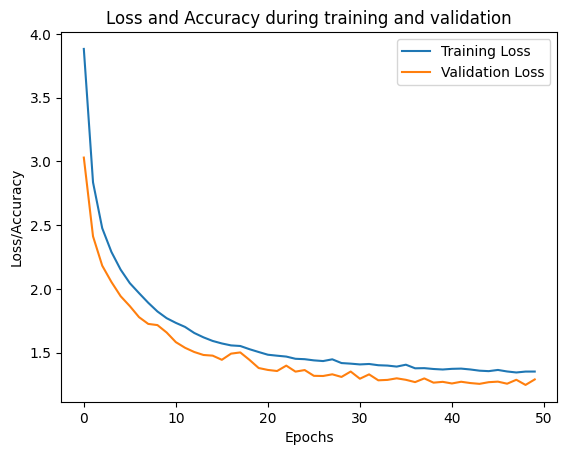

In [69]:
plt.plot(history_sleep_quality.history['loss'], label='Training Loss')
plt.plot(history_sleep_quality.history['val_loss'], label='Validation Loss')
plt.title('Loss during training and validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()